In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.6MB 646kB/s 


In [ ]:
!pip install opacus

     |████████████████████████████████| 92kB 5.8MB/s 


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
import os
import opacus
from opacus import PrivacyEngine
from collections import OrderedDict

In [ ]:
# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
#            'wide_resnet50_2', 'wide_resnet101_2']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
#     'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
#     'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
#     'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
#     'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
# }

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k, kernel_size = 5, stride = 1):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels*k, kernel_size, stride)
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size = 2)
    
    def forward(self, x):
        x = self.conv(x)
        out = self.pool(self.tanh(x))
        
        return out 

### Vanilla LeNet

In [ ]:
# class LeNet5(nn.Module):

#     def __init__(self, n_classes):
#         super(LeNet5, self).__init__()
        
#         self.feature_extractor = nn.Sequential( OrderedDict([          
#             ("conv1", nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)),
#             ("tanh1", nn.Tanh()),
#             ("pool1", nn.AvgPool2d(kernel_size=2)),
#             ("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
#             ("tanh2", nn.Tanh()),
#             ("pool1", nn.AvgPool2d(kernel_size=2)),
#             ("conv3", nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)),
#             ("tanh3", nn.Tanh())
#         ]))

#         self.classifier = nn.Sequential(OrderedDict([
#             ("fc1", nn.Linear(in_features=120, out_features=84)),
#             ("tanh4", nn.Tanh()),
#             ("fc2", nn.Linear(in_features=84, out_features=n_classes))
#         ]))


#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = torch.flatten(x, 1)
#         logits = self.classifier(x)
#         return logits

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size= 4, stride=1, padding = 0),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=120*2*2, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
      x = self.feature_extractor(x)
      logits = self.classifier(x)
      return logits

In [ ]:
from torchsummary import summary
model = LeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_LeNet5.pth')
# model.load_state_dict(x['model'])
model.cuda()
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 29, 29]             102
              Tanh-2            [-1, 6, 29, 29]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 11, 11]           1,552
              Tanh-5           [-1, 16, 11, 11]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 2, 2]          30,840
              Tanh-8            [-1, 120, 2, 2]               0
           Flatten-9                  [-1, 480]               0
           Linear-10                   [-1, 84]          40,404
             Tanh-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 73,748
Trainable params: 73,748
Non-trainable params: 0
---------------------------------

In [ ]:
model

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=480, out_features=84, bias=True)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Wide LeNet with Linear Bottle Neck

In [ ]:
class Linear_WideLeNet5(nn.Module):

    def __init__(self, n_classes):
        super(Linear_WideLeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding = 1),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding = 1),
            nn.Conv2d(in_channels=8, out_channels=62, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=62, out_channels=11, kernel_size=1, stride=1, padding = 1),
            nn.Conv2d(in_channels=11, out_channels=120, kernel_size=5, stride=1, padding = 0),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features = 120*3*3, out_features= 120),
            nn.Tanh(),
            nn.Linear(in_features = 120, out_features=n_classes),
        )


    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor(x)
        #print(x.shape)
        x = x.view(-1, 120*3*3)
        #print(x.shape)
        logits = self.classifier(x)
        #print(logits.shape)
        return logits

In [ ]:
from torchsummary import summary
Linear_WideLeNet5 = Linear_WideLeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_L_LeNet5.pth')
# Linear_WideLeNet5.load_state_dict(x['model'])
Linear_WideLeNet5.cuda()
summary(Linear_WideLeNet5, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,832
            Conv2d-5            [-1, 8, 14, 14]             264
            Conv2d-6           [-1, 62, 10, 10]          12,462
              Tanh-7           [-1, 62, 10, 10]               0
         AvgPool2d-8             [-1, 62, 5, 5]               0
            Conv2d-9             [-1, 11, 7, 7]             693
           Conv2d-10            [-1, 120, 3, 3]          33,120
             Tanh-11            [-1, 120, 3, 3]               0
           Linear-12                  [-1, 120]         129,720
             Tanh-13                  [-1, 120]               0
           Linear-14                   

In [ ]:
Linear_WideLeNet5

Linear_WideLeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(8, 62, kernel_size=(5, 5), stride=(1, 1))
    (6): Tanh()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(62, 11, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(11, 120, kernel_size=(5, 5), stride=(1, 1))
    (10): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=1080, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)

### Wide LeNet with Non-Linear Bottle Neck

In [ ]:
class Non_Linear_WideLeNet5(nn.Module):

    def __init__(self, n_classes):
        super(Non_Linear_WideLeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding = 1),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding = 1),
            nn.Tanh(),
            nn.Conv2d(in_channels=8, out_channels=62, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=62, out_channels=11, kernel_size=1, stride=1, padding = 1),
            nn.Tanh(),
            nn.Conv2d(in_channels=11, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features = 120*3*3, out_features= 120),
            nn.Tanh(),
            nn.Linear(in_features = 120, out_features =  n_classes),
        )


    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor(x)
        #print(x.shape)
        x = x.view(-1, 120*3*3)
        #print(x.shape)
        logits = self.classifier(x)
        #print(logits.shape)
        return logits

In [ ]:
from torchsummary import summary
Non_Linear_WideLeNet5 = Non_Linear_WideLeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_NL_LeNet5.pth')
# Non_Linear_WideLeNet5.load_state_dict(x['model'])
Non_Linear_WideLeNet5.cuda()
summary(Non_Linear_WideLeNet5, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,832
              Tanh-5           [-1, 32, 12, 12]               0
            Conv2d-6            [-1, 8, 14, 14]             264
              Tanh-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 62, 10, 10]          12,462
              Tanh-9           [-1, 62, 10, 10]               0
        AvgPool2d-10             [-1, 62, 5, 5]               0
           Conv2d-11             [-1, 11, 7, 7]             693
             Tanh-12             [-1, 11, 7, 7]               0
           Conv2d-13            [-1, 120, 3, 3]          33,120
             Tanh-14            [-1, 12

In [ ]:
Non_Linear_WideLeNet5

Non_Linear_WideLeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
    (7): Conv2d(8, 62, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(62, 11, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
    (12): Conv2d(11, 120, kernel_size=(5, 5), stride=(1, 1))
    (13): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=1080, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)

In [ ]:
best_acc = []
best_train_acc = best_test_acc = start_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer1 = optim.Adam(Linear_WideLeNet5.parameters(), lr = 0.001)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last = True)

testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2, drop_last = True)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# tr_X, tr_Y = [], []
# te_X, te_Y = [], []

# for _, (images, labels) in enumerate(trainloader):
#   tr_X.append(images)
#   tr_Y.append(labels)

# # trainX = np.array(trainX)
# # trainY = np.array(trainY)

In [ ]:
# print(tr_X[0].shape)

In [ ]:
# for _, (images, labels) in enumerate(testloader):
#   te_X.append(images)
#   te_Y.append(labels)

# print(te_X[0].shape, te_Y[0].shape)

In [ ]:
# trainX, trainY, testX, testY = [], [], [], []

# print(len(tr_X[0]))

# # for image in tr_X:


In [ ]:
def train(model, epoch, delta=1e-5):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  e = 0
  a = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[6].parameters().requires_grad = True
      optimizer.zero_grad()
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
      epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(delta)

      e += epsilon
      a+= best_alpha

      print(f'Epoch {epoch+1} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total),  f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}")
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
  

  print(f'\nEpoch {epoch+1}', 'Loss: %.3f | Acc: %.3f'
                % (train_loss/(batch_idx+1), total_acc/len(trainloader)),  f"(ε = {e/len(trainloader):.2f}, δ = {delta}) for α = {a/len(trainloader)}\n")
  
  return total_acc/len(trainloader)

In [ ]:
def test(model, epoch, model_name, lr):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          # print(inputs.shape, inputs[0].shape)
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

          print(f'Epoch {epoch+1} Step {batch_idx}/{len(testloader)}', 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  total_acc += acc
  if acc > best_test_acc:
      print('Saving..')
      state = {
          'model': model.state_dict(),
          'acc': acc,
          'epoch': epoch,
      }
      if not os.path.isdir('/content/drive/My Drive/checkit'):
          os.mkdir('/content/drive/My Drive/checkit')
      torch.save(state, f'/content/drive/My Drive/checkit/ckpt_{model_name}_{lr}_MNIST.pth')
      best_test_acc = acc
      
  return total_acc

In [ ]:
def train_wide(model, epoch, delta=1e-5):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[9].parameters().requires_grad = True
      optimizer1.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer1.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
      epsilon, best_alpha = optimizer1.privacy_engine.get_privacy_spent(delta)

      print(f'Epoch {epoch+1} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total), f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}")
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
          
  return total_acc/len(trainloader)

In [ ]:
def train_NLwide(model, epoch, delta=1e-5):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[12].parameters().requires_grad = True
      optimizer2.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer2.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()
      epsilon, best_alpha = optimizer1.privacy_engine.get_privacy_spent(delta)

      print(f'Epoch {epoch} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total), f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}")
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
          
  return total_acc/len(trainloader)

In [ ]:
# for name, layer in Linear_WideLeNet5.named_modules(self):
#   if isinstance(layer, nn.Conv2d):
#     print(name, layer)

In [ ]:
batch_size = sample_size = 64
lr = 1.3

LeNet5_train_acc = []
L_WideLeNet5_train_acc = []
NL_WideLeNet5_train_acc = []

LeNet5_test_acc = []
L_WideLeNet5_test_acc = []
NL_WideLeNet5_test_acc = []

privacy_engine = PrivacyEngine(
    model,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier= lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer)

for epoch in range(start_epoch, start_epoch+50):
    LeNet5_train_acc.append([train(model, epoch), epoch+1])
    LeNet5_test_acc.append([test(model, epoch, 'LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:112: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:291: UserWarning: PrivacyEngine expected a batch of size 64 but the last step received a batch of size 32. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Streaming output truncated to the last 5000 lines.
Epoch 48 Step 1574/1875 Loss: 0.953 | Acc: 77.087% (38852/50400) (ε = 265385.89, δ = 1e-05) for α = 10
Epoch 48 Step 1575/1875 Loss: 0.953 | Acc: 77.088% (38877/50432) (ε = 265388.85, δ = 1e-05) for α = 10
Epoch 48 Step 1576/1875 Loss: 0.953 | Acc: 77.079% (38897/50464) (ε = 265391.81, δ = 1e-05) for α = 10
Epoch 48 Step 1577/1875 Loss: 0.953 | Acc: 77.083% (38924/50496) (ε = 265394.77, δ = 1e-05) for α = 10
Epoch 48 Step 1578/1875 Loss: 0.953 | Acc: 77.088% (38951/50528) (ε = 265397.73, δ = 1e-05) for α = 10
Epoch 48 Step 1579/1875 Loss: 0.953 | Acc: 77.093% (38978/50560) (ε = 265400.69, δ = 1e-05) for α = 10
Epoch 48 Step 1580/1875 Loss: 0.952 | Acc: 77.093% (39003/50592) (ε = 265403.65, δ = 1e-05) for α = 10
Epoch 48 Step 1581/1875 Loss: 0.952 | Acc: 77.088% (39025/50624) (ε = 265406.60, δ = 1e-05) for α = 10
Epoch 48 Step 1582/1875 Loss: 0.952 | Acc: 77.096% (39054/50656) (ε = 265409.56, δ = 1e-05) for α = 10
Epoch 48 Step 1583/187

In [ ]:
print(best_acc)

[[87.5, 80.65905448717949]]


In [ ]:
# Training Wide_ResNet16
best_train_acc = best_test_acc = 0
privacy_engine = PrivacyEngine(
    Linear_WideLeNet5,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier=lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer1)

for epoch in range(start_epoch, start_epoch+50):
  L_WideLeNet5_train_acc.append([train_wide(Linear_WideLeNet5, epoch), epoch+1])
  L_WideLeNet5_test_acc.append([test(Linear_WideLeNet5, epoch, 'L_LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:112: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:291: UserWarning: PrivacyEngine expected a batch of size 64 but the last step received a batch of size 32. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Streaming output truncated to the last 5000 lines.
Epoch 48 Step 1565/1875 Loss: 1.901 | Acc: 59.760% (29947/50112) (ε = 265359.27, δ = 1e-05) for α = 10
Epoch 48 Step 1566/1875 Loss: 1.901 | Acc: 59.760% (29966/50144) (ε = 265362.23, δ = 1e-05) for α = 10
Epoch 48 Step 1567/1875 Loss: 1.901 | Acc: 59.750% (29980/50176) (ε = 265365.18, δ = 1e-05) for α = 10
Epoch 48 Step 1568/1875 Loss: 1.901 | Acc: 59.745% (29997/50208) (ε = 265368.14, δ = 1e-05) for α = 10
Epoch 48 Step 1569/1875 Loss: 1.901 | Acc: 59.747% (30017/50240) (ε = 265371.10, δ = 1e-05) for α = 10
Epoch 48 Step 1570/1875 Loss: 1.901 | Acc: 59.745% (30035/50272) (ε = 265374.06, δ = 1e-05) for α = 10
Epoch 48 Step 1571/1875 Loss: 1.902 | Acc: 59.739% (30051/50304) (ε = 265377.02, δ = 1e-05) for α = 10
Epoch 48 Step 1572/1875 Loss: 1.902 | Acc: 59.739% (30070/50336) (ε = 265379.98, δ = 1e-05) for α = 10
Epoch 48 Step 1573/1875 Loss: 1.902 | Acc: 59.734% (30087/50368) (ε = 265382.94, δ = 1e-05) for α = 10
Epoch 48 Step 1574/187

In [ ]:
best_train_acc = best_test_acc = 0
optimizer2 = optim.Adam(Non_Linear_WideLeNet5.parameters(), lr = 0.001)
privacy_engine = PrivacyEngine(
    Non_Linear_WideLeNet5,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier=lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer2)

for epoch in range(start_epoch, start_epoch+50):
  NL_WideLeNet5_train_acc.append([train_NLwide(Non_Linear_WideLeNet5, epoch), epoch+1])
  NL_WideLeNet5_test_acc.append([test(Non_Linear_WideLeNet5, epoch, 'NL_LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:112: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:291: UserWarning: PrivacyEngine expected a batch of size 64 but the last step received a batch of size 32. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Streaming output truncated to the last 5000 lines.
Epoch 47 Step 1565/1875 Loss: 1.194 | Acc: 73.112% (36638/50112) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1566/1875 Loss: 1.194 | Acc: 73.109% (36660/50144) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1567/1875 Loss: 1.194 | Acc: 73.107% (36682/50176) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1568/1875 Loss: 1.194 | Acc: 73.108% (36706/50208) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1569/1875 Loss: 1.194 | Acc: 73.105% (36728/50240) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1570/1875 Loss: 1.194 | Acc: 73.104% (36751/50272) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1571/1875 Loss: 1.194 | Acc: 73.106% (36775/50304) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1572/1875 Loss: 1.193 | Acc: 73.111% (36801/50336) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1573/1875 Loss: 1.194 | Acc: 73.114% (36826/50368) (ε = 277368.14, δ = 1e-05) for α = 10
Epoch 47 Step 1574/187

In [ ]:
print(best_acc)

[[87.5, 80.65905448717949], [84.375, 77.28365384615384], [90.625, 81.65064102564102]]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# print(LeNet5_train_acc)
# print(LeNet5_test_acc)
train_deep_acc = []
test_deep_acc = []

train_LinearWide_acc = []
test_LinearWide_acc = []

train_NonLinearWide_acc = []
test_NonLinearWide_acc = []

epoch = np.arange(1, 51, 1)
# print(epoch)

In [ ]:
for acc, _ in LeNet5_train_acc:
  train_deep_acc.append(acc)
for acc, _ in LeNet5_test_acc:
  test_deep_acc.append(acc)

for acc, _ in NL_WideLeNet5_train_acc:
  train_LinearWide_acc.append(acc)
for acc, _ in NL_WideLeNet5_test_acc:
  test_LinearWide_acc.append(acc)

for acc, _ in NL_WideLeNet5_train_acc:
  train_NonLinearWide_acc.append(acc)
for acc, _ in NL_WideLeNet5_test_acc:
  test_NonLinearWide_acc.append(acc)

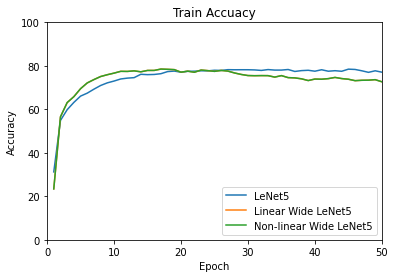

In [ ]:
plt.title('Train Accuacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 100])
plt.plot(epoch, train_deep_acc, label='LeNet5')
plt.plot(epoch, train_LinearWide_acc, label= 'Linear Wide LeNet5')
plt.plot(epoch, train_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'lower right')

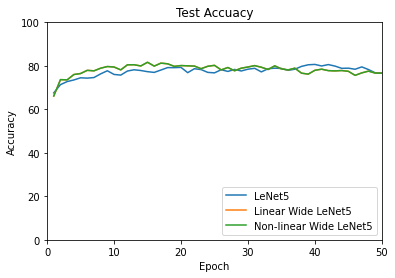

In [ ]:
plt.title('Test Accuacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 100])
plt.plot(epoch, test_deep_acc, label='LeNet5')
plt.plot(epoch, test_LinearWide_acc, label= 'Linear Wide LeNet5')
plt.plot(epoch, test_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'lower right')

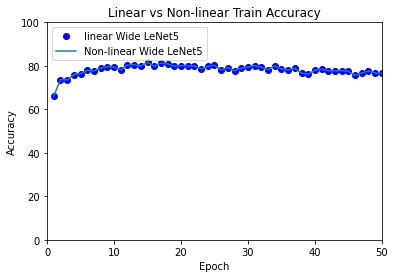

In [ ]:
plt.title('Linear vs Non-linear Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 100])
plt.plot(epoch, test_LinearWide_acc, 'bo', label= 'linear Wide LeNet5')
plt.plot(epoch, test_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'upper left')

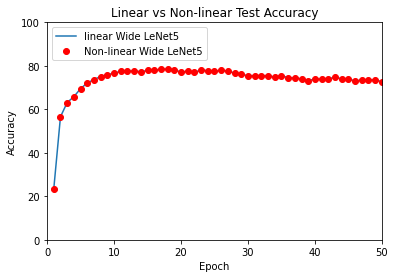

In [ ]:
plt.title('Linear vs Non-linear Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 100])
plt.plot(epoch, train_LinearWide_acc, label= 'linear Wide LeNet5')
plt.plot(epoch, train_NonLinearWide_acc, 'ro', label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'upper left')